In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime

sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

sadcp_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'u_sadcp', 'v_sadcp', 'lat_sadcp', 'lon_sadcp', 'z_sadcp', 'tim_sadcp'])

In [2]:
def plot_ellipse(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):

        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse
    

In [3]:
u, v, lat, lon, z, tim = sadcp_data['u_sadcp'], sadcp_data['v_sadcp'], sadcp_data['lat_sadcp'], sadcp_data['lon_sadcp'], sadcp_data['z_sadcp'], sadcp_data['tim_sadcp']
def julian_to_datetime(jd):
    # Julian date of the Unix epoch (Jan 1, 1970) is 2440587.5
    unix_time = (jd - 2440587.5) * 86400.0  # seconds since Unix epoch
    return datetime.datetime.utcfromtimestamp(unix_time)

tim_datetime = []
for t in tim:
    tim_datetime.append(julian_to_datetime(t))


In [4]:
def espra(xi, yi, ui, vi):
    from scipy.optimize import least_squares
    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])
    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 
    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)
    w = 2*(q11 + q22)
    Q = np.array([[q11, q12], [q12, q22]])
    return x0, y0, Q, w

def moca(u1, v1, l):

    def find_root(x, y):
        coeffs = np.polyfit(x, y, 3)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid = x[len(x)//2]
        return real_roots[np.argmin(np.abs(mid - real_roots))]

    def tang_at_root(x, y, rx):
        coeffs = np.polyfit(x, y, 3)
        deriv = np.polyder(coeffs)
        slope = np.polyval(deriv, rx)
        intercept = np.polyval(coeffs, rx) - slope * rx
        return slope, intercept
    
    def cubic_interpolate(x, y, root):
        coeffs = np.polyfit(x, y, 3)
        return np.polyval(coeffs, root)

    root = find_root(l, v1)
    c, b = tang_at_root(l, v1, root)  # c: slope, b: intercept
    a = cubic_interpolate(l, u1, root)
    
    x0 = -b / c
    y0 = a / c
    w = 2 * c
    
    return x0, y0, w 

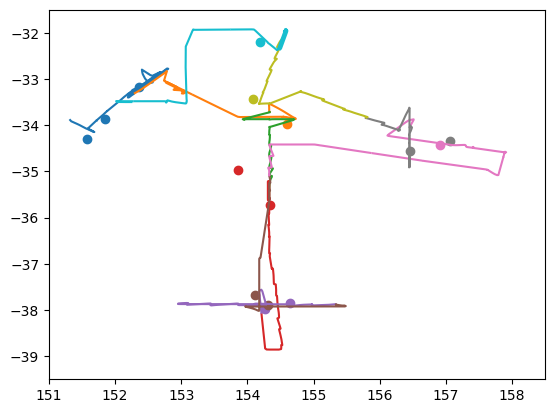

In [5]:
u_data = pd.DataFrame(u, columns=tim_datetime, index=z)
v_data = pd.DataFrame(v, columns=tim_datetime, index=z)

depth = 37
ship_data = pd.DataFrame({'Time': tim_datetime, 'Lon': lon, 'Lat': lat, 'u': u_data.loc[depth], 'v': v_data.loc[depth]}).dropna()
ship_data = ship_data.set_index('Time')

unique_days = sorted(set(ship_data.index.date))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_days)))
for day, color in zip(unique_days, colors):
    day_data = ship_data[ship_data.index.date == day]
    plt.plot(day_data['Lon'], day_data['Lat'], color=color, label=str(day))

    xi, yi, ui, vi = day_data['Lon'], day_data['Lat'], day_data['u'], day_data['v']
    x0, y0, Q, w = espra(xi, yi, ui, vi)
    
    plt.scatter(x0, y0, color=color)

plt.xlim(151, 158.5)
plt.ylim(-39.5, -31.5)
# plt.legend(title='Day')
plt.show()

In [6]:
# # Assuming ship_data is already defined with a datetime index
# # Create a new column that floors the time to the nearest 6-hour period
# ship_data['6h'] = ship_data.index.floor('6h')

# # Get the unique 6-hour periods in sorted order
# unique_periods = sorted(ship_data['6h'].unique())

# # Create a color map with a distinct color for each period
# colors = plt.cm.tab10(np.linspace(0, 1, len(unique_periods)))

# # Loop over each 6-hour period, plot the segment and associated scatter points
# for period, color in zip(unique_periods, colors):
#     period_data = ship_data[ship_data['6h'] == period]
#     plt.plot(period_data['Lon'], period_data['Lat'], color=color, label=str(period))
    
#     # Extract the data for the espra function (assuming espra is defined)
#     xi, yi, ui, vi = period_data['Lon'], period_data['Lat'], period_data['u'], period_data['v']
#     x0, y0, q11, q12, q22, w = espra(xi, yi, ui, vi)
#     plt.scatter(x0, y0, color=color)

# plt.xlim(151, 158.5)
# plt.ylim(-39.5, -31.5)
# plt.show()


In [7]:
import glob
import netCDF4 as nc
from netCDF4 import Dataset, num2date

def convert_to_datetime(time_val, time_variable):
    dt = num2date(time_val, units=time_variable.units,
                  calendar=getattr(time_variable, 'calendar', 'gregorian'))
    try:
        return [d.to_pydatetime() if hasattr(d, 'to_pydatetime') else d for d in dt]
    except TypeError:
        return dt.to_pydatetime() if hasattr(dt, 'to_pydatetime') else dt

nc_files = glob.glob('/srv/scratch/z5297792/IN2023/marina_observational_data/IN23_SSH/*.nc')

time_ssh = []
filenames = []
df_ssh_times = pd.DataFrame(columns=['Time', 'fname'])
for filename in nc_files:
    with nc.Dataset(filename, mode='r') as ssh_data:
        # Convert the first time value in the TIME variable
        dt = convert_to_datetime(ssh_data['TIME'][:], ssh_data.variables['TIME'])[0]
        df_ssh_times.loc[len(df_ssh_times)] = {'Time': dt, 'fname': filename}
df_ssh_times = df_ssh_times.sort_values(by='Time').reset_index(drop=True)
df_ssh_times = df_ssh_times.set_index('Time')

df_ssh_times


,fname
Time,
2023-10-06 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-07 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-08 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-09 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-10 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-11 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-12 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-13 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-14 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...


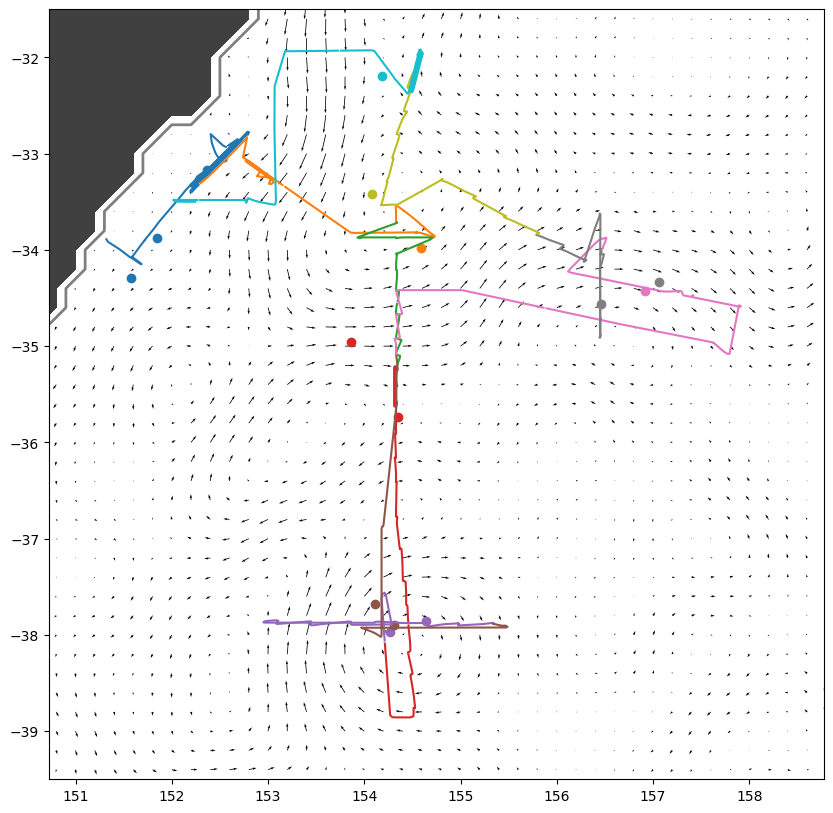

In [8]:
ssh_data = nc.Dataset(df_ssh_times.iloc[0]['fname'], mode='r')

LON, LAT = ssh_data['LONGITUDE'][:].data.squeeze(), ssh_data['LATITUDE'][:].data.squeeze()
LON, LAT = np.meshgrid(LON, LAT)
ucur, vcur = ssh_data['UCUR'][:].data.squeeze(), ssh_data['VCUR'][:].data.squeeze()
ucur, vcur = np.where(np.abs(ucur) > 100, np.nan, ucur), np.where(np.abs(vcur) > 100, np.nan, vcur)

plt.figure(figsize=(10,10))

spacing = 1
plt.quiver(LON[::spacing, ::spacing], LAT[::spacing, ::spacing], ucur[::spacing, ::spacing], vcur[::spacing, ::spacing], scale=50, width=.001)

unique_days = sorted(set(ship_data.index.date))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_days)))
for day, color in zip(unique_days, colors):
    day_data = ship_data[ship_data.index.date == day]
    plt.plot(day_data['Lon'], day_data['Lat'], color=color, label=str(day))

    xi, yi, ui, vi = day_data['Lon'], day_data['Lat'], day_data['u'], day_data['v']
    x0, y0, Q, w = espra(xi, yi, ui, vi)
    
    plt.scatter(x0, y0, color=color)
    
mask = (LON > 148) & (LON < 160) & (LAT > -42) & (LAT < -28)
ucur = np.where(mask, ucur, 0)
if np.any(np.isnan(ucur)):
    nan_mask = np.isnan(ucur)
    mask = np.where(~np.isnan(ucur), np.nan, 0)
    plt.contourf(LON, LAT, mask, cmap='gray', zorder=-1)
    plt.contour(LON, LAT, nan_mask, colors='k', linewidths=2, alpha=.5)

plt.axis('equal')
plt.xlim(151, 158.5)
plt.ylim(-39.5, -31.5)
plt.show()

In [9]:
# Interested in CE south of -36
CE_ship_data = ship_data[ship_data['Lat'] < -36.5]
CE_ship_data['D'] = CE_ship_data.index.floor('D')
CE_unique_days = sorted(set(CE_ship_data.index.date)) # The days we sail over the CE
# Get SSH data during our sail over the CE
CE_unique_days_set = set(CE_unique_days)
mask = [datetime.date(t.year, t.month, t.day) in CE_unique_days_set for t in df_ssh_times.index]
CE_filtered_df = df_ssh_times[mask]
CE_filtered_df.index = CE_filtered_df.index.round('D')
CE_filtered_df

/scratch/pbs.6365794.kman.restech.unsw.edu.au/ipykernel_2983266/3815498014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CE_ship_data['D'] = CE_ship_data.index.floor('D')


,fname
Time,
2023-10-17 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-18 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-19 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-20 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-21 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-22 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...


In [10]:
CE_ship_data

,Lon,Lat,u,v,D
Time,,,,,
2023-10-17 03:27:30.333314,154.333956,-36.504093,0.098432,0.043512,2023-10-17
2023-10-17 03:42:30.666672,154.333527,-36.526944,0.151867,-0.037615,2023-10-17
2023-10-17 03:57:30.333327,154.333137,-36.549652,0.194339,-0.092730,2023-10-17
2023-10-17 04:12:31.000017,154.332717,-36.572059,0.213763,-0.129165,2023-10-17
2023-10-17 04:27:30.666672,154.332233,-36.598470,0.209848,-0.169332,2023-10-17
...,...,...,...,...,...
2023-10-22 01:42:30.333327,154.220278,-36.667095,0.194414,0.103064,2023-10-22
2023-10-22 01:57:30.666685,154.224880,-36.625156,0.123789,0.220929,2023-10-22
2023-10-22 02:12:30.333340,154.229619,-36.583336,0.221843,0.141765,2023-10-22


/scratch/pbs.6365794.kman.restech.unsw.edu.au/ipykernel_2983266/333960994.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x0_moca, y0_moca, w_moca = moca(ui, vi, xi-xi[0])
/scratch/pbs.6365794.kman.restech.unsw.edu.au/ipykernel_2983266/2824028444.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mid = x[len(x)//2]


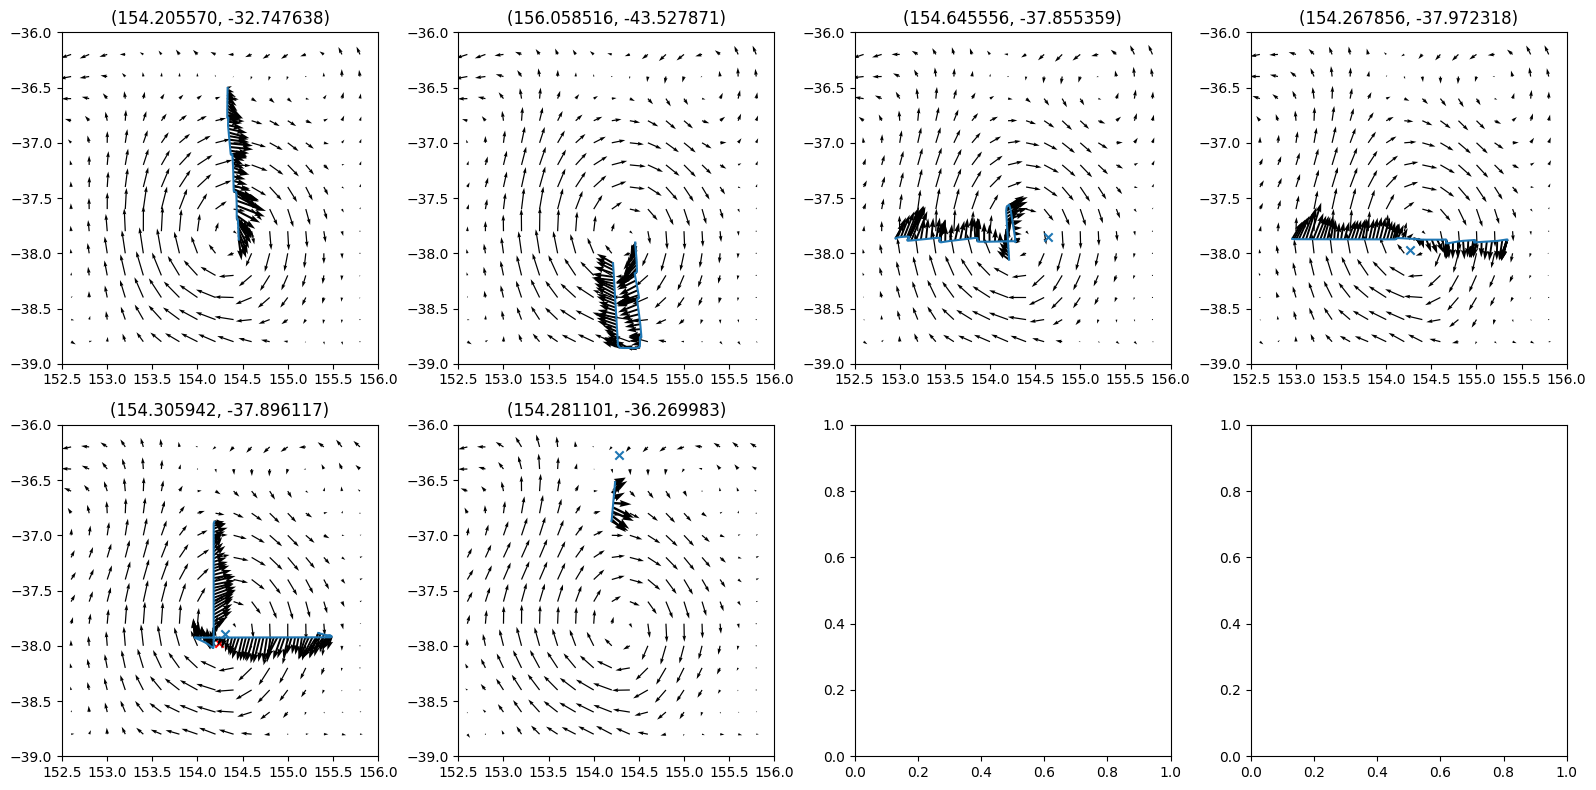

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

xmin, xmax = 152.5, 156
ymin, ymax = -39, -36

for d, day in enumerate(CE_unique_days):
    ax = axs[d // 4, d % 4]

    # PLOT SSH DATA
    with nc.Dataset(CE_filtered_df.iloc[d]['fname'], mode='r') as ds:
        lon = ds['LONGITUDE'][:].squeeze()
        lat = ds['LATITUDE'][:].squeeze()
        lon, lat = np.meshgrid(lon, lat)
        u = ds['UCUR'][:].squeeze()
        v = ds['VCUR'][:].squeeze()
    u = np.where(np.abs(u) > 100, np.nan, u)
    v = np.where(np.abs(v) > 100, np.nan, v)
    mask = (lon > xmin) & (lon < xmax) & (lat > ymin) & (lat < ymax)
    idx = np.where(mask)
    spacing = 1
    ax.quiver(lon[idx][::spacing], lat[idx][::spacing], u[idx][::spacing], v[idx][::spacing], scale=None, width=None)

    # PLOT RV DATA
    day = pd.Timestamp(day)
    day_data = CE_ship_data[day==CE_ship_data['D']]

    xi, yi, ui, vi = day_data['Lon'], day_data['Lat'], day_data['u'], day_data['v']
    x0, y0, Q, w = espra(xi, yi, ui, vi)

    if d == 4:
        x0_moca, y0_moca, w_moca = moca(ui, vi, xi-xi[0])
    
        x0_moca += xi.iloc[0] 
        y0_moca += yi.iloc[0]

        ax.scatter(x0_moca, y0_moca, marker='x', color='r')

    ax.plot(xi, yi)
    ax.quiver(xi, yi, ui, vi)
    
    ax.scatter(x0, y0, marker='x')
    ax.set_title(f'({x0:02f}, {y0:02f})')

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [12]:
timestamps = CE_ship_data.index # roughly every 15 min = .25 Hr
t_int = 24*3*4
df_CE_trace = pd.DataFrame(columns=['x0', 'y0', 'w', 'Q', 'Time'])
for t_start in timestamps[:-t_int]:

    t_end = t_start + pd.Timedelta(hours=t_int)

    xi = CE_ship_data[(CE_ship_data.index > t_start) & (CE_ship_data.index < t_end)]['Lon']
    yi = CE_ship_data[(CE_ship_data.index > t_start) & (CE_ship_data.index < t_end)]['Lat']
    ui = CE_ship_data[(CE_ship_data.index > t_start) & (CE_ship_data.index < t_end)]['u']
    vi = CE_ship_data[(CE_ship_data.index > t_start) & (CE_ship_data.index < t_end)]['v']

    x0, y0, Q, w = espra(xi, yi, ui, vi)

    df_CE_trace.loc[len(df_CE_trace)] = {'x0': x0, 'y0': y0, 'w': w, 'Q': Q, 'Time': t_start + (t_end - t_start) / 2}

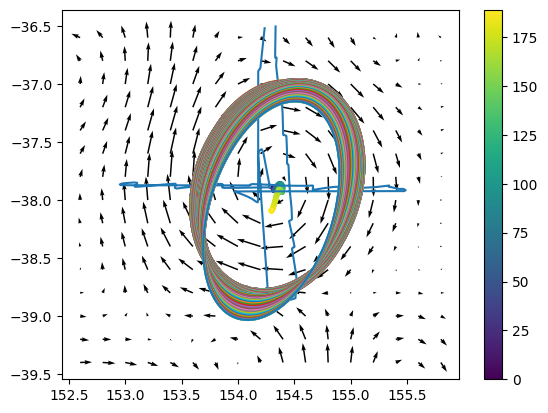

In [13]:
# PLOT SSH DATA
with nc.Dataset(CE_filtered_df.iloc[4]['fname'], mode='r') as ds:
    lon = ds['LONGITUDE'][:].squeeze()
    lat = ds['LATITUDE'][:].squeeze()
    lon, lat = np.meshgrid(lon, lat)
    u = ds['UCUR'][:].squeeze()
    v = ds['VCUR'][:].squeeze()
u = np.where(np.abs(u) > 100, np.nan, u)
v = np.where(np.abs(v) > 100, np.nan, v)
mask = (lon > 152.5) & (lon < 156) & (lat > -39.5) & (lat < -36.5)
idx = np.where(mask)
spacing = 1
plt.quiver(lon[idx][::spacing], lat[idx][::spacing], u[idx][::spacing], v[idx][::spacing], scale=None, width=None)

# t1, t2 = 0, 100
t1, t2 = 0, len(df_CE_trace)

plt.plot(CE_ship_data.iloc[t1:t2+t_int]['Lon'], CE_ship_data.iloc[t1:t2+t_int]['Lat'])

plt.scatter(df_CE_trace.iloc[t1:t2]['x0'], df_CE_trace.iloc[t1:t2]['y0'], c=df_CE_trace.iloc[t1:t2].index, s=10)
plt.colorbar()

for (x0, y0, Q) in zip(df_CE_trace['x0'],df_CE_trace['y0'],df_CE_trace['Q']):
    x_ellipse, y_ellipse = plot_ellipse(Q, center=(x0, y0), scale=1)
    plt.plot(x_ellipse, y_ellipse)



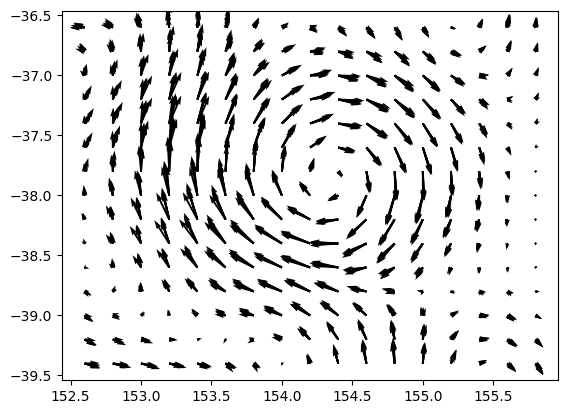

In [14]:
for d in range(len(CE_filtered_df)):
    with nc.Dataset(CE_filtered_df.iloc[d]['fname'], mode='r') as ds:
        lon = ds['LONGITUDE'][:].squeeze()
        lat = ds['LATITUDE'][:].squeeze()
        lon, lat = np.meshgrid(lon, lat)
        u = ds['UCUR'][:].squeeze()
        v = ds['VCUR'][:].squeeze()
    u = np.where(np.abs(u) > 100, np.nan, u)
    v = np.where(np.abs(v) > 100, np.nan, v)
    mask = (lon > 152.5) & (lon < 156) & (lat > -39.5) & (lat < -36.5)
    idx = np.where(mask)
    spacing = 1
    plt.quiver(lon[idx][::spacing], lat[idx][::spacing], u[idx][::spacing], v[idx][::spacing], scale=None, width=None)

#### CE2

In [15]:
# Interested in CE south of -36
CE2_ship_data = ship_data[ship_data['Lon'] > 155.5]
CE2_ship_data['D'] = CE2_ship_data.index.floor('D')
CE2_unique_days = sorted(set(CE2_ship_data.index.date)) # The days we sail over the CE
# Get SSH data during our sail over the CE
CE2_unique_days_set = set(CE2_unique_days)
mask = [datetime.date(t.year, t.month, t.day) in CE2_unique_days_set for t in df_ssh_times.index]
CE2_filtered_df = df_ssh_times[mask]
CE2_filtered_df.index = CE2_filtered_df.index.round('D')
CE2_ship_data

/scratch/pbs.6365794.kman.restech.unsw.edu.au/ipykernel_2983266/1427560536.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CE2_ship_data['D'] = CE2_ship_data.index.floor('D')


,Lon,Lat,u,v,D
Time,,,,,
2023-10-23 21:12:30.333327,155.500982,-34.522681,0.545942,0.642845,2023-10-23
2023-10-23 21:27:30.666685,155.536558,-34.530314,0.495317,0.632437,2023-10-23
2023-10-23 21:42:30.333340,155.571805,-34.537906,0.350272,0.532976,2023-10-23
2023-10-23 21:57:29.666664,155.605763,-34.545219,0.196818,0.453509,2023-10-23
2023-10-23 22:12:30.333314,155.638077,-34.552141,0.113505,0.484958,2023-10-23
...,...,...,...,...,...
2023-10-28 02:27:30.666659,155.708364,-33.774317,0.231813,0.037051,2023-10-28
2023-10-28 02:42:30.333314,155.662402,-33.753858,0.196776,-0.021060,2023-10-28
2023-10-28 02:57:30.000009,155.614920,-33.732419,0.099254,-0.014628,2023-10-28


In [16]:
timestamps = CE2_ship_data.index # roughly every 15 min = .25 Hr
t_int = 24*3*4
df_CE2_trace = pd.DataFrame(columns=['x0', 'y0', 'w', 'Q', 'Time'])
for t_start in timestamps[:-t_int]:

    t_end = t_start + pd.Timedelta(hours=t_int)

    xi = CE2_ship_data[(CE2_ship_data.index > t_start) & (CE2_ship_data.index < t_end)]['Lon']
    yi = CE2_ship_data[(CE2_ship_data.index > t_start) & (CE2_ship_data.index < t_end)]['Lat']
    ui = CE2_ship_data[(CE2_ship_data.index > t_start) & (CE2_ship_data.index < t_end)]['u']
    vi = CE2_ship_data[(CE2_ship_data.index > t_start) & (CE2_ship_data.index < t_end)]['v']

    x0, y0, Q, w = espra(xi, yi, ui, vi)

    df_CE2_trace.loc[len(df_CE2_trace)] = {'x0': x0, 'y0': y0, 'w': w, 'Q': Q, 'Time': t_start + (t_end - t_start) / 2}

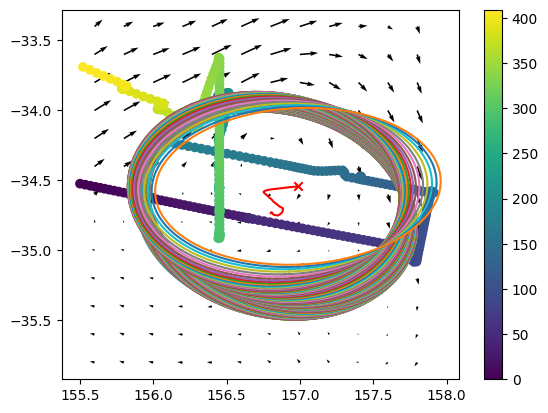

In [17]:
xmin, xmax = 155.5, 158
ymin, ymax = -36, -33.4

with nc.Dataset(CE2_filtered_df.iloc[4]['fname'], mode='r') as ds:
    lon = ds['LONGITUDE'][:].squeeze()
    lat = ds['LATITUDE'][:].squeeze()
    lon, lat = np.meshgrid(lon, lat)
    u = ds['UCUR'][:].squeeze()
    v = ds['VCUR'][:].squeeze()
u = np.where(np.abs(u) > 100, np.nan, u)
v = np.where(np.abs(v) > 100, np.nan, v)
mask = (lon > xmin) & (lon < xmax) & (lat > ymin) & (lat < ymax)
idx = np.where(mask)
spacing = 1
plt.quiver(lon[idx][::spacing], lat[idx][::spacing], u[idx][::spacing], v[idx][::spacing], scale=20, width=.004)

plt.scatter(CE2_ship_data['Lon'], CE2_ship_data['Lat'], c=np.arange(len(CE2_ship_data)))
plt.colorbar()

# plt.quiver(CE2_ship_data['Lon'], CE2_ship_data['Lat'], CE2_ship_data['u'], CE2_ship_data['v'], color='r')

plt.plot(df_CE2_trace['x0'], df_CE2_trace['y0'], 'r')
plt.scatter(df_CE2_trace.iloc[-1]['x0'], df_CE2_trace.iloc[-1]['y0'], marker='x', color='r')

for (x0, y0, Q) in zip(df_CE2_trace['x0'],df_CE2_trace['y0'],df_CE2_trace['Q']):
    x_ellipse, y_ellipse = plot_ellipse(Q, center=(x0, y0), scale=1)
    plt.plot(x_ellipse, y_ellipse)


In [18]:
df_CE2_trace

,x0,y0,w,Q,Time
0,156.801357,-34.733354,-1.231095,"[[-0.23708141958321968, -0.03164810802384446],...",2023-10-29 21:12:30.333327
1,156.802994,-34.731097,-1.236121,"[[-0.23756080449256858, -0.033450076470142094]...",2023-10-29 21:27:30.666685
2,156.804410,-34.729543,-1.240439,"[[-0.23820824363097254, -0.034797544920214474]...",2023-10-29 21:42:30.333340
3,156.805521,-34.728756,-1.243634,"[[-0.23890929796082686, -0.03562226706279618],...",2023-10-29 21:57:29.666664
4,156.806083,-34.728401,-1.245221,"[[-0.23927841552905754, -0.03601342389615636],...",2023-10-29 22:12:30.333314
...,...,...,...,...,...
117,156.878420,-34.554514,-1.378659,"[[-0.20055384530609502, 0.00813061856215762], ...",2023-10-31 02:27:30.333327
118,156.904417,-34.551058,-1.354513,"[[-0.18909554070257859, 0.011184130257062629],...",2023-10-31 02:42:30.666685
119,156.932357,-34.547834,-1.332128,"[[-0.17846784870549967, 0.013705851520234492],...",2023-10-31 02:57:30.333340
120,156.960565,-34.545212,-1.312637,"[[-0.16921512579726503, 0.015494145686118031],...",2023-10-31 03:12:29.666664


## MOCA

In [19]:
def straighten(x, y, u, v, n=None):
    from scipy.interpolate import interp1d
    x, y, u, v = np.asarray(x), np.asarray(y), np.asarray(u), np.asarray(v)
    n = n or len(x)
    m, b = np.polyfit(x, y, 1)
    pts = np.column_stack((x, y))
    vec = np.array([1, m])
    vec /= np.linalg.norm(vec)
    ref = pts[0]
    d = np.dot(pts - ref, vec)
    d_uniform = np.linspace(d.min(), d.max(), n)
    u_new = interp1d(d, u, kind='linear')(d_uniform)
    v_new = interp1d(d, v, kind='linear')(d_uniform)
    pts_new = ref + np.outer(d_uniform, vec)
    ut_new = u_new * vec[0] + v_new * vec[1]
    norm = np.array([-vec[1], vec[0]])
    un_new = u_new * norm[0] + v_new * norm[1]
    return pts_new[:, 0], pts_new[:, 1], u_new, v_new, ut_new, un_new


In [20]:
CE_filtered_df

,fname
Time,
2023-10-17 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-18 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-19 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-20 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-21 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...
2023-10-22 18:00:00,/srv/scratch/z5297792/IN2023/marina_observatio...


In [21]:
CE_ship_data

,Lon,Lat,u,v,D
Time,,,,,
2023-10-17 03:27:30.333314,154.333956,-36.504093,0.098432,0.043512,2023-10-17
2023-10-17 03:42:30.666672,154.333527,-36.526944,0.151867,-0.037615,2023-10-17
2023-10-17 03:57:30.333327,154.333137,-36.549652,0.194339,-0.092730,2023-10-17
2023-10-17 04:12:31.000017,154.332717,-36.572059,0.213763,-0.129165,2023-10-17
2023-10-17 04:27:30.666672,154.332233,-36.598470,0.209848,-0.169332,2023-10-17
...,...,...,...,...,...
2023-10-22 01:42:30.333327,154.220278,-36.667095,0.194414,0.103064,2023-10-22
2023-10-22 01:57:30.666685,154.224880,-36.625156,0.123789,0.220929,2023-10-22
2023-10-22 02:12:30.333340,154.229619,-36.583336,0.221843,0.141765,2023-10-22


-19.130720671386996
-4.533547843390115
0.45869491692668163
-3.4816249528088603
-5.477762440109392
1.2432567461519475


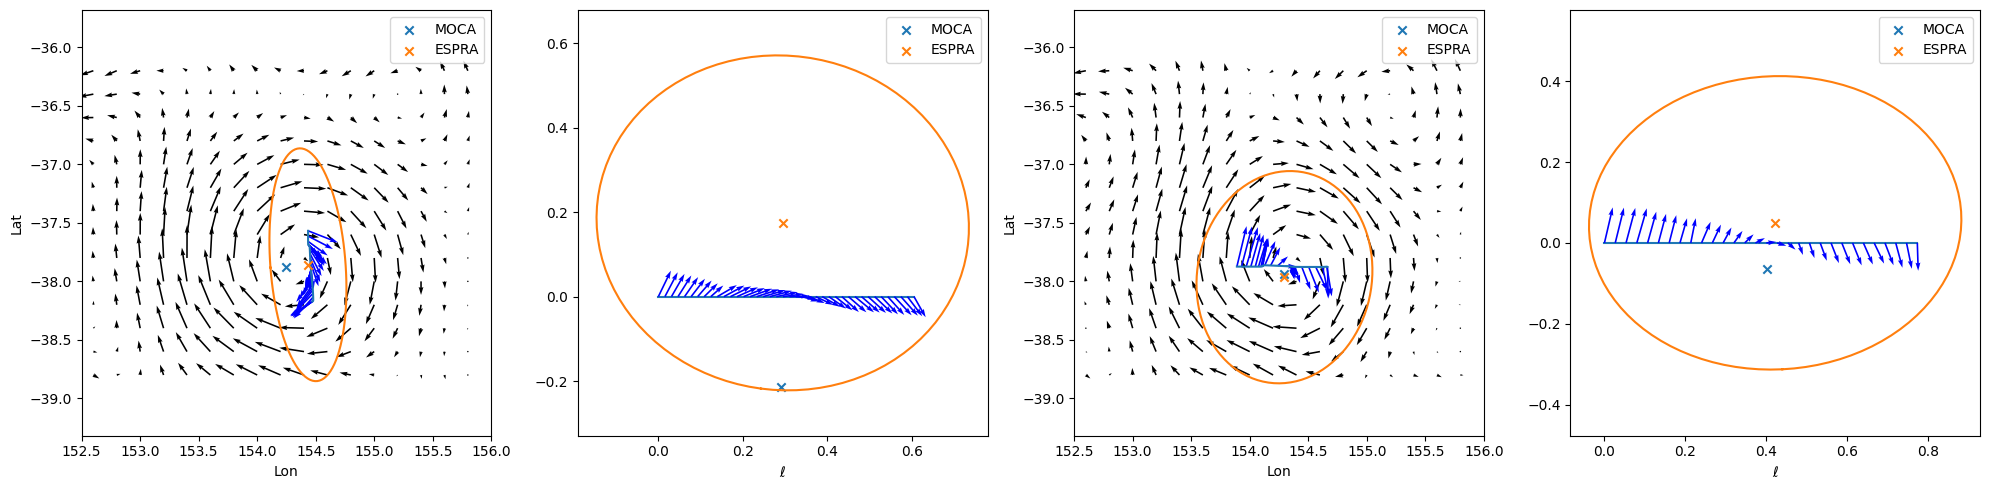

In [22]:
def find_closest_date(cftime_dates, target):
    if not isinstance(target, pd.Timestamp):
        target = pd.Timestamp(target)
    ts_dates = [pd.Timestamp(d.isoformat()) for d in cftime_dates]
    return min(ts_dates, key=lambda d: abs(d - target))

def compute_v_unit(x, y):
    dx = x[-1] - x[0]
    dy = y[-1] - y[0]
    norm = np.sqrt(dx**2 + dy**2)
    return np.array([dx / norm, dy / norm])
    
def find_point(ref, v_unit, d_along, d_perp):
    return ref + d_along * v_unit + d_perp * np.array([-v_unit[1], v_unit[0]])

# Define plot limits and time indices
xmin, xmax = 152.5, 156
ymin, ymax = -39, -36
width = 0.004

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# for e, (t1, t2) in enumerate([(60, 180), (300, 420)]):
for e, (t1, t2) in enumerate([(65, 105), (300, 330)]):

    t_mean = CE_ship_data.iloc[t1:t2].index.mean()
    
    # Retrieve the closest date and corresponding filename
    closest_date = find_closest_date(np.array(CE_filtered_df.index), t_mean)
    fname = CE_filtered_df.loc[closest_date]['fname']
    
    # Plot SSH Data
    with nc.Dataset(fname, mode='r') as ds:
        lon = ds['LONGITUDE'][:].squeeze()
        lat = ds['LATITUDE'][:].squeeze()
        lon, lat = np.meshgrid(lon, lat)
        u = ds['UCUR'][:].squeeze()
        v = ds['VCUR'][:].squeeze()
    
    u = np.where(np.abs(u) > 100, np.nan, u)
    v = np.where(np.abs(v) > 100, np.nan, v)
    
    mask = (lon > xmin) & (lon < xmax) & (lat > ymin) & (lat < ymax)
    idx = np.where(mask)
    
    spacing = 1
    axs[0+2*e].quiver(
        lon[idx][::spacing], lat[idx][::spacing],
        u[idx][::spacing], v[idx][::spacing],
        scale=None, width=None
    )
    
    # Plot RV Data
    day_data = CE_ship_data.iloc[t1:t2]
    xi = np.array(day_data['Lon'])
    yi = np.array(day_data['Lat'])
    ui = np.array(day_data['u'])
    vi = np.array(day_data['v'])

    # plot 1
    x0_espra, y0_espra, Q_espra, w_espra = espra(xi, yi, ui, vi)
    axs[0+2*e].plot(xi, yi)
    axs[0+2*e].quiver(xi, yi, ui, vi, color='b',width=width)
    xi, yi, ui, vi, V_T, V_N = straighten(xi, yi, ui, vi)
    print(w_espra)
    l = np.hypot(xi - xi[0], yi - yi[0])

    x0l, y0l, w = moca(V_T, V_N, l)
    print(w)

    v_unit = compute_v_unit(xi, yi)
    ref = np.array([xi[0], yi[0]])
    x0, y0 = find_point(ref, v_unit, x0l, y0l)

    axs[0+2*e].scatter(x0, y0, marker='x', label='MOCA', zorder=5)
    axs[0+2*e].scatter(x0_espra, y0_espra, marker='x', label='ESPRA', zorder=5)
    x_ell, y_ell = plot_ellipse(Q_espra, (x0_espra, y0_espra))
    axs[0+2*e].plot(x_ell, y_ell)
    
    axs[0+2*e].legend()
    axs[0+2*e].axis('equal')
    axs[0+2*e].set_xlim(xmin, xmax)
    axs[0+2*e].set_ylim(ymin, ymax)
    axs[0+2*e].set_xlabel('Lon')
    axs[0+2*e].set_ylabel('Lat')
    
    # plot 2
    
    axs[1+2*e].plot(l, np.zeros_like(l))
    axs[1+2*e].quiver(l, np.zeros_like(l), V_T, V_N, color='b', zorder=3, width=width)
    axs[1+2*e].scatter(x0l, y0l, marker='x', label='MOCA')
    x0_espral, y0_espral, Q_espral, w_espral = espra(l, [0]*len(l), V_T, V_N)
    print(w_espral)
    x_ell, y_ell = plot_ellipse(Q_espral, (x0_espral, y0_espral), scale=.5)
    axs[1+2*e].plot(x_ell, y_ell)
    axs[1+2*e].scatter(x0_espral, y0_espral, marker='x',  label='ESPRA')
    
    axs[1+2*e].legend()
    axs[1+2*e].set_xlabel(r'$\ell$')
    axs[1+2*e].axis('equal')

plt.tight_layout()
plt.show()


MOCA producing reasonable results, ESPRA however clearly struggles using linear data. 

## Drifers

In [23]:
from datetime import datetime

drifter_path = '/srv/scratch/z5297792/IN2023/2023_CCE_drifters.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')
u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
tim_drif = drifter_dataset['time'][:].data

xmin, xmax = 151, 156
ymin, ymax = -39, -36

mask = (lon_drif >= xmin) & (lon_drif <= xmax) & (lat_drif >= ymin) & (lat_drif <= ymax)
u_drif, v_drif, lon_drif, lat_drif, tim_drif = u_drif[mask], v_drif[mask], lon_drif[mask], lat_drif[mask], tim_drif[mask]
dt_strings = [b''.join(row).decode('utf-8') for row in tim_drif]
dt_objects = [datetime.fromisoformat(s) for s in dt_strings]

df_drif = pd.DataFrame({'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': dt_objects}).dropna()

spike_indices = np.where(np.hypot(df_drif['Lon'].diff(), df_drif['Lat'].diff()) > .5)[0]

df_drif1 = df_drif[:spike_indices[0]]
df_drif2 = df_drif[spike_indices[0]:spike_indices[1]]
df_drif3 = df_drif[spike_indices[1]:spike_indices[2]]
df_drif4 = df_drif[spike_indices[2]:spike_indices[3]]
df_drif5 = df_drif[spike_indices[3]:]

def find_spike_indices(dt_list):
    spike_indices = []
    # Start from index 1 since there's no previous value for index 0
    for i in range(1, len(dt_list)):
        if dt_list[i] < dt_list[i - 1]:
            spike_indices.append(i)
    return spike_indices

drift1 = df_drif2

spike_indices = find_spike_indices(np.array(df_drif3['Time']))
drift2 = df_drif3.iloc[spike_indices[0]:]

spike_indices = find_spike_indices(np.array(df_drif5['Time']))
drift3 = df_drif5.iloc[spike_indices[0]:]


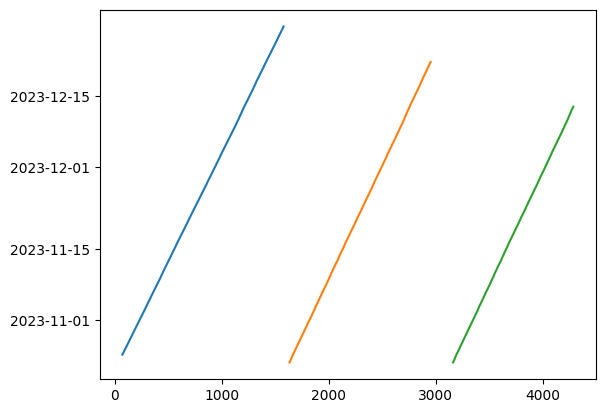

In [24]:
plt.plot(drift1['Time'])
plt.plot(drift2['Time'])
plt.plot(drift3['Time'])

In [25]:
df_drif

,Lon,Lat,u,v,Time
0,152.752487,-37.422474,-0.287410,-0.125541,2023-10-22 02:42:00
1,152.743805,-37.428650,-0.625086,-0.268273,2023-10-22 03:42:00
2,152.733505,-37.442516,-0.629687,-0.266857,2023-10-22 04:00:00
3,152.722229,-37.457474,-0.279366,-0.116640,2023-10-22 05:00:00
4,152.714508,-37.471188,-0.222752,-0.064746,2023-10-22 06:00:00
...,...,...,...,...,...
4281,152.583237,-37.210903,-0.261002,-0.154695,2023-12-12 18:00:00
4282,152.567017,-37.222069,-0.300502,-0.209841,2023-12-12 19:00:00
4283,152.552780,-37.233448,-0.307547,-0.251971,2023-12-12 20:00:00
4284,152.538651,-37.245686,-0.295753,-0.309900,2023-12-12 21:00:00


-0.08032841828375362
0.4277968157518469
1.11459648468597


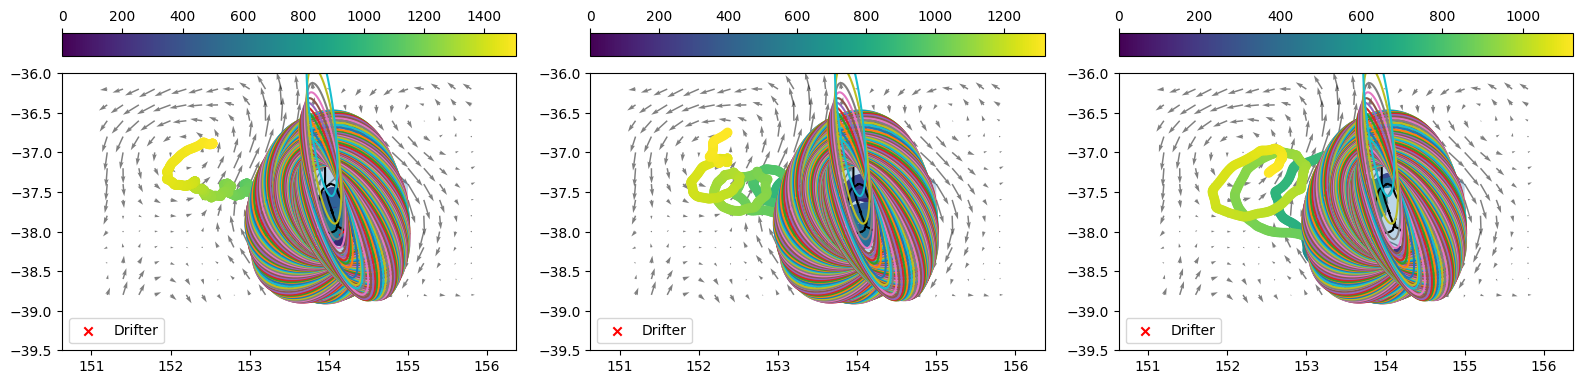

In [26]:
from scipy.spatial import ConvexHull

with nc.Dataset(CE_filtered_df.iloc[-1]['fname'], mode='r') as ds:
    lon = ds['LONGITUDE'][:].squeeze()
    lat = ds['LATITUDE'][:].squeeze()
    lon, lat = np.meshgrid(lon, lat)
    u = ds['UCUR'][:].squeeze()
    v = ds['VCUR'][:].squeeze()
u = np.where(np.abs(u) > 100, np.nan, u)
v = np.where(np.abs(v) > 100, np.nan, v)
mask = (lon > xmin) & (lon < xmax) & (lat > ymin) & (lat < ymax)
idx = np.where(mask)

# Calculate the trace of the eddy center

t1_drift1_min, t1_drift2_min, t1_drift3_min = drift1['Time'].min(), drift2['Time'].min(), drift3['Time'].min()
t_min = max(t1_drift1_min, t1_drift2_min, t1_drift3_min)
t1_drift1_max, t1_drift2_max, t1_drift3_max = drift1['Time'].max(), drift2['Time'].max(), drift3['Time'].max()
t_max = min(t1_drift1_max, t1_drift2_max, t1_drift3_max)
df_all = pd.concat([drift1, drift2, drift3], ignore_index=True)
timestamps = pd.date_range(start=t_min, end=t_max, freq='h')

# df_all = df_drif # use all the data
# t_min, t_max = df_drif['Time'].min(), df_drif['Time'].max()
# timestamps = pd.date_range(start=t_min, end=t_max, freq='h')

fig, axs = plt.subplots(1, 3, figsize=(16,4))

t_int = 72 # hours
df_trace = pd.DataFrame(columns=['x0', 'y0', 'w', 'Q', 'Time'])
for t_start in timestamps[:-t_int]:

    t_end = t_start + pd.Timedelta(hours=t_int)

    xi = df_all[(df_all['Time'] > t_start) & (df_all['Time'] < t_end)]['Lon']
    yi = df_all[(df_all['Time'] > t_start) & (df_all['Time'] < t_end)]['Lat']
    ui = df_all[(df_all['Time'] > t_start) & (df_all['Time'] < t_end)]['u']
    vi = df_all[(df_all['Time'] > t_start) & (df_all['Time'] < t_end)]['v']

    x0, y0, Q, w = espra(xi, yi, ui, vi)

    df_trace.loc[len(df_trace)] = {'x0': x0, 'y0': y0, 'w': w, 'Q': Q, 'Time': t_start + (t_end - t_start) / 2}

# idx1, idx2 = 0, 580 # 300 hr int
# idx1, idx2 = 0, 378 # 100 hr int
idx1, idx2 = 0, 270 # 72 hr int
# axs[0].scatter(df_trace.iloc[idx1:idx2]['x0'], df_trace.iloc[idx1:idx2]['y0'],c=np.arange(len(df_trace.iloc[idx1:idx2])))
axs[0].plot(df_trace.iloc[idx1:idx2]['x0'], df_trace.iloc[idx1:idx2]['y0'], 'k')
axs[1].plot(df_trace.iloc[idx1:idx2]['x0'], df_trace.iloc[idx1:idx2]['y0'], 'k')
axs[2].plot(df_trace.iloc[idx1:idx2]['x0'], df_trace.iloc[idx1:idx2]['y0'], 'k')

for (x0, y0, Q) in zip(df_trace.iloc[idx1:idx2]['x0'], df_trace.iloc[idx1:idx2]['y0'], df_trace.iloc[idx1:idx2]['Q']):
    x_ellipse, y_ellipse = plot_ellipse(Q, center=(x0, y0), scale=1)
    axs[0].plot(x_ellipse, y_ellipse)
    axs[1].plot(x_ellipse, y_ellipse)
    axs[2].plot(x_ellipse, y_ellipse)
    

for i, df in enumerate([drift1, drift2, drift3]):
    spacing = 1
    axs[i].quiver(lon[idx][::spacing], lat[idx][::spacing], u[idx][::spacing], v[idx][::spacing], scale=None, width=None, alpha=.5)
    
    c = np.arange(len(df))
    sc = axs[i].scatter(df['Lon'], df['Lat'], c=c)
    fig.colorbar(sc, ax=axs[i], location='top', orientation='horizontal')
    
    # axs[i].quiver(df['Lon'], df['Lat'], df['u'], df['v'], color='r', scale=20)
    r = 1
    mask = np.hypot(lon - 154.2, lat - (-37.9)) < r
    points = np.column_stack((lon[mask].data, lat[mask].data))
    if len(points) > 2: 
        hull = ConvexHull(points)
        axs[i].fill(points[hull.vertices, 0], points[hull.vertices, 1], alpha=0.3)

    xi, yi, ui, vi = df['Lon'], df['Lat'], df['u'], df['v']
    mask = np.hypot(xi - 154.2, yi - (-37.9)) < r
    x0, y0, Q, w = espra(xi[mask], yi[mask], ui[mask], vi[mask])
    print(w)
    axs[i].scatter(x0, y0, marker='x', color='r', label='Drifter')

    axs[i].axis('equal')
    axs[i].set_xlim(xmin, xmax)
    axs[i].set_ylim(ymin-.5, ymax)
    axs[i].legend()

plt.tight_layout()
plt.show()


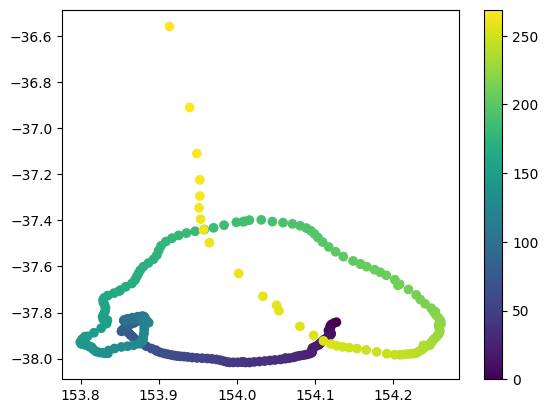

In [27]:
idx1, idx2 = 0, 270
plt.scatter(df_trace.iloc[idx1:idx2]['x0'], df_trace.iloc[idx1:idx2]['y0'],c=np.arange(len(df_trace.iloc[idx1:idx2])))
plt.colorbar()

# plt.xlim(151, 156)
# plt.ylim( -41, -36)

In [28]:
df_trace

,x0,y0,w,Q,Time
0,154.127052,-37.842009,2.233349,"[[0.6570555744121003, -0.1392909901519691], [-...",2023-10-26 17:00:00
1,154.123701,-37.846233,2.262600,"[[0.6663267317564813, -0.13904516242285553], [...",2023-10-26 18:00:00
2,154.120525,-37.852397,2.285755,"[[0.6719114988104573, -0.1364198446211668], [-...",2023-10-26 19:00:00
3,154.119227,-37.859186,2.293018,"[[0.6699107474156698, -0.1319200135714491], [-...",2023-10-26 20:00:00
4,154.119454,-37.865002,2.290241,"[[0.6639364010847306, -0.12726916542018904], [...",2023-10-26 21:00:00
...,...,...,...,...,...
1093,152.725816,-36.823787,0.425955,"[[0.20451886493139224, 0.06512470596982656], [...",2023-12-11 06:00:00
1094,152.684573,-36.642825,0.458670,"[[0.2178376694815453, 0.06191537651734096], [0...",2023-12-11 07:00:00
1095,151.712088,-32.795560,0.492430,"[[0.23157425847006421, 0.059251039662817], [0....",2023-12-11 08:00:00
1096,152.898551,-37.477469,0.523521,"[[0.24432110287775746, 0.05579657812815838], [...",2023-12-11 09:00:00
